In [ ]:
fpath = "/home/stc/devspace/codes/SpinEchoSim/"

# CPU
include(join([fpath,"SpinEchoSim_cpu.jl"]))

# GPU
#using CUDA
#include(join([fpath,"SpinEchoSim_gpu.jl"]))

In [10]:
### setup the job

# make the parameter file
params = make_params()

# Jobs: Gaussian, Power, RKKY, AFM Power, P_power, d_power

# interaction
params["α"] = LinRange(0, 0.1, 5)#LinRange(0.001, 0.005, 3)#[0.000,0.005,0.01];#3*0.015;
params["α_z"] = 0.5 .- (5*params["α"]);
#params["α_fac"] = [0.5,2,1,6,8,6];
#params["α_fac"] = [1,1,1,1,1,1];
#params["M_op"] = params["Iy"]

# number of frequencies
params["n"] = (20, 20)

params["τ"] = convert.(Float32,100e-6)
params["dt"] = convert.(Float32, 1)
#params["line_width"] = 0.01
#params["bw"] = 0.1

# make a lattice, pbc = periodic bc or not
params["hlk"] = [1; 1]
params["θ"] = [π/2]
params["r"], params["spin_idx"] = make_lattice(params["hlk"], params["θ"], params["n"])

# make the stencil
params["ξ"] = 8
params["decay_power"] = 3

#params["func_type"] = [0,1,2,1,1,1] # 0: gauss, 1: power, 2: RKKY
#params["afm"] = [false, false, false, true, false, false];
#params["s_w"] = [1.0, 1.0, 1.0, 1.0, 0.0, 0.0];
#params["p_w"] = [0.0, 0.0, 0.0, 0.0, 1.0, 0.0];
#params["d_w"] = [0.0, 0.0, 0.0, 0.0, 0.0, 1.0];

params["func_type"] = 0 # 0: gauss, 1: power, 2: RKKY, 3: uniform
params["afm"] = false;
params["s_w"] = 1.0
params["p_w"] = 0.0
params["d_w"] = 0.0

func_type = 3;    
params["M_stencil"] = make_stencil(params["r"], params["ξ"], params["decay_power"],func_type)
# dissipation parameters
params["Γ"] = (0, 0, 10^-7);

# load the pulsing parameters
params["flip_angle"] = LinRange(0.0,6.0,9*4+1) .* π/2;
params["phases"] = (0, π/2)

# cpmg parameters
params["echo_time"] = 100e-6 # collect(LinRange(50e-6, 300e-6, 20));
params["num_echoes"] = convert.(Int64, round.(1000e-6./params["echo_time"]));

# set the variables
#vars = ["α",("α_fac","func_type","afm","s_w","p_w","d_w")]
vars = [("α","α_z"),"flip_angle"]
params["vars"] = vars;

# generate indexing (needed for temp_params function)
I, d = make_idx(vars, params);
println(params["α"])
println(params["α_z"])
for th in params["flip_angle"]
    print(string(round(180/π * th)," "))
end
print("\n")


range(0.0, stop=0.1, length=5)
range(0.5, stop=0.0, length=5)
0.0 15.0 30.0 45.0 60.0 75.0 90.0 105.0 120.0 135.0 150.0 165.0 180.0 195.0 210.0 225.0 240.0 255.0 270.0 285.0 300.0 315.0 330.0 345.0 360.0 375.0 390.0 405.0 420.0 435.0 450.0 465.0 480.0 495.0 510.0 525.0 540.0 


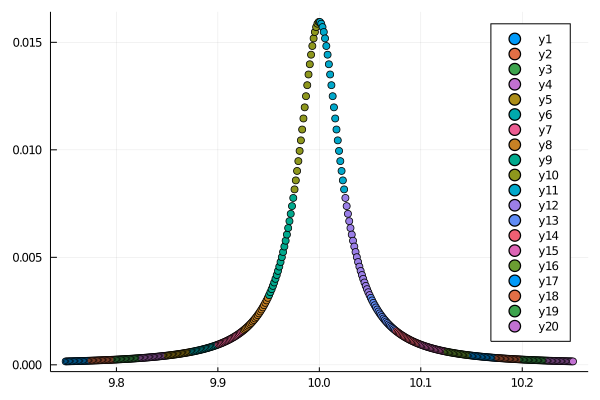

In [11]:
using Plots

tparams = make_temp_params(params, vars, I[1]);
scatter(tparams["ν"],tparams["P"])
#histogram( broadcast(real,tparams["ν"][:]),bins=300)

In [12]:
# simulate
M = Array{Any}(undef,size(I))
for idx in I
    # generate temporary parameters
    tparams = make_temp_params(params, vars, idx);
    #tparams["M_stencil"] = make_stencil(tparams["r"], tparams["ξ"], tparams["decay_power"],tparams["func_type"],tparams["afm"],tparams["s_w"],tparams["p_w"],tparams["d_w"])
    #tparams["ν"] = tparams["ν"] .+ 0.1;
    @time M[idx] = spin_echo_sim_liouville(tparams);        
    #@time M[idx] = spin_echo_sim(tparams);        

end
println("done!")

 21.571664 seconds (43.39 M allocations: 23.211 GiB, 7.32% gc time)
  8.836063 seconds (11.48 M allocations: 21.774 GiB, 11.53% gc time)
  8.868650 seconds (11.48 M allocations: 21.774 GiB, 11.54% gc time)
  8.823806 seconds (11.48 M allocations: 21.774 GiB, 11.42% gc time)
  8.809033 seconds (11.48 M allocations: 21.774 GiB, 11.33% gc time)
  8.847058 seconds (11.48 M allocations: 21.774 GiB, 11.21% gc time)
  8.806888 seconds (11.48 M allocations: 21.774 GiB, 11.13% gc time)
  8.824925 seconds (11.48 M allocations: 21.774 GiB, 11.06% gc time)
  8.813523 seconds (11.48 M allocations: 21.774 GiB, 11.03% gc time)
  8.870719 seconds (11.48 M allocations: 21.774 GiB, 10.87% gc time)
  8.757652 seconds (11.48 M allocations: 21.774 GiB, 10.90% gc time)
  9.080603 seconds (11.48 M allocations: 21.774 GiB, 13.24% gc time)
  9.037188 seconds (11.48 M allocations: 21.774 GiB, 12.72% gc time)
  9.036151 seconds (11.48 M allocations: 21.774 GiB, 12.78% gc time)
  9.045394 seconds (11.48 M allocat

In [13]:
using Plots
p = Vector{Any}(undef,size(M)[2])
N = 1;#prod(size(params["r"]));
dh = 0.5;
t_max = 3.0*params["τ"]*1e6


for run_idx in 1:size(M)[2]
    p[run_idx] = plot()
    for alpha_idx in 1:size(M)[1]
        t = LinRange(0, t_max, size(M[alpha_idx,run_idx], 1));

        p[run_idx] = plot!(t,broadcast(real,M[alpha_idx,run_idx])/N .+ dh*(alpha_idx-1),linecolor=:red)
        p[run_idx] = plot!(t,broadcast(imag,M[alpha_idx,run_idx])/N .+ dh*(alpha_idx-1),linecolor=:blue)
        p[run_idx] = plot!([0,t_max], dh*(alpha_idx-1) .+ [0,0], linecolor=:black, linestyle=:dash)
    end
end

#plot(p[1],p[2],p[3],legend=false,size=(400,500))
plot(p[1],p[2],p[3],p[4],p[5],p[6],p[7],layout=(1,7),legend=false,size=(1200,300))


In [23]:
using FFTW
using LaTeXStrings

ν0 = params["ν0"]

t_max = 2*params["τ"]*1e6; # 200 micro seconds
f = params["flip_angle"];

alph_list = params["α"]
alph_z_list = params["α_z"]

dt_start = 0;
dt_end = dt_start;

M0 = convert(Array{Complex{Float64}},M[1,1])
nt = size(M0, 1)

# select a truncated window to FFT
M0_trunc = M0[convert(Int64,round(nt/3 + dt_start)):convert(Int64,round(nt - dt_end))]
ntrunc = size(M0_trunc,1)
t = LinRange(0, t_max, size(M0_trunc, 1))
dt = t[2]-t[1]
t_envelope = 1 ./(1 .+ exp.(-0.1 .* (t .- 120)))
t_envelope = t_envelope .* reverse(t_envelope)

alpha_list = params["α"]
alpha_z_list = params["α_z"]

zn = 13;
zero_pad = zeros(Complex{Float64},2*2^zn + ntrunc)

# figure out the "frequency axis" after the FFT
Fs = 1/dt;
N = size(zero_pad,1)
freq_ax = (((0:N-1) .+ 1/2)/N .- 1/2)*Fs;
# pulse sweep

p = Vector{Any}(undef,size(M)[1])

for alpha_idx = [1,4,5]#1:size(M)[1]
    p[alpha_idx] = plot();
    for run_idx in 1:size(M)[2]
        # load in the M data
        M0 = convert(Array{Complex{Float64}},M[alpha_idx,run_idx])

        # select a truncated window to FFT
        M0_trunc = t_envelope .* M0[convert(Int64,round(nt/3 + dt_start)):convert(Int64,round(nt - dt_end))]
        M0_trunc_z = zero_pad
        M0_trunc_z[(2^zn+1):(2^zn + ntrunc)] = M0_trunc
        3
        ang_here = (f[run_idx]*180/π);
        ang_str = string(round(ang_here),"°");
        power_str = string("[", round(alpha_z_list[alpha_idx],digits=3), ", ", round(alpha_list[alpha_idx],digits=3) , "]");

        # labeling
        alpha_str = latexstring("\\textrm{",round(alpha_list[alpha_idx],digits=4),"}")
        c_x = (run_idx-size(M)[2]/2)/size(M)[2]
        color_here = RGB(0.5+.5*c_x,0.5,0.5-c_x)
        # plot the time-domian results
        M0_trunc_abs = broadcast(abs,M0_trunc) # normalize
        M0_trunc_abs = M0_trunc_abs/maximum(M0_trunc_abs)
        #plot!(plt3,t, M0_trunc_abs .+ 2*(run_idx-1),label="",color=color_here,linewidth=2, xlim=[t[1],t[length(t)]])
        #plot!(plt3,t, 0*M0_trunc_abs .+ 2*(run_idx-1),color=RGB(0,0,0),linestyle=:dash,label="")

        # FFT!
        M0_fft = fftshift(fft(fftshift(M0_trunc_z)))

        M0_fft = M0_fft/maximum(broadcast(abs,broadcast(imag,M0_fft))) # normalize

        plot!(p[alpha_idx],freq_ax .+ ν0, 0*broadcast(imag,M0_fft) .+ 2*(run_idx-1),color=RGB(0,0,0),linestyle=:dash,label="")
        plot!(p[alpha_idx],freq_ax .+ ν0,   broadcast(abs,broadcast(imag,M0_fft)) .+ 2*(run_idx-1),xlim=ν0 .+ [-0.4,0.4],label="",color=color_here,linewidth=2)

        if (run_idx == 1)
            #annotate!(plt2,11.15,0.5+2*(alpha_idx-1),text(alpha_str,color_here, :right,12))
            plot!(p[alpha_idx],ν0 .+ [0,0],[0, 2*size(M)[2]],color=RGB(0,0,0),label="",linestyle=:dot,linewidth=1)
            annotate!(p[alpha_idx],10.0, 13.75,text(power_str,color_here, :center,8))
        end
        if true #(mod(run_idx,4) == 0)#(run_idx == 1 || run_idx == 4 || run_idx == 7)
            annotate!(p[alpha_idx],10.1, 0.9 + 2*(run_idx-1),text(ang_str,color_here, :left,8))
        end
    end
    
    w_ax = [9.75, 10.25];
    plot!(p[alpha_idx],xlim=w_ax,xticks=[9.8,10,10.2])
    xlabel!(p[alpha_idx],"frequency (MHz)")
    #annotate!(p[alpha_idx],10.1,+0.9 + 2*(run_idx-1),text(ang_str,color_here, :left,8))
    
end

cos_func_z = LinRange(0,2*size(M)[2],100)
cos_func_theta = LinRange(0,pi*3.0,100)
cos_amp = -0.125
cos_func = cos_amp*(cos.(cos_func_theta) + cos.(3 .* cos_func_theta));
sin_func = -0.4*cos_amp*(cos.(2 .* cos_func_theta) )
sign_invert = (mod.(cos_func_theta,2*pi) .> 0.75*pi) .* ( mod.(cos_func_theta,2*pi) .< 1.25*pi)
sin_func = -(2 .* sign_invert .- 1) .* sin_func

mix_func = 0.1*cos_amp*(cos.(cos_func_theta) + cos.(3 .* cos_func_theta));


plot!(p[1],yticks=[])
plot!(p[1],10 .+ cos_func, cos_func_z,label="",linestyle=:dash,color=RGB(1,0,0))
#plot!(p[4],10 .+ mix_func, cos_func_z,label="",linestyle=:dash,color=RGB(1,0,0))
plot!(p[5],10 .+ sin_func, cos_func_z,label="",linestyle=:dash,color=RGB(1,0,0))

ylabel!(p[1],"|M|")

fig_x = 2*40*10;
fig_y = 2*35*10;
#plot(p[1],p[2],p[3],p[4],p[5],layout=(1,5),size=(fig_x,fig_y))
plot(p[1],p[4],p[5],layout=(1,3),size=(fig_x,fig_y))
#plot(p[4],size=(fig_x/3.0,fig_y))

#savefig("alpha_ratio_sweep_540_fits_06-09-2021.pdf")
